In [109]:
import re

import pandas as pd # getting the data
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

seed = 17

In [110]:
df = pd.read_csv('ICPSR_04572/DS0001/04572-0001-Data.tsv', sep='\t')
df.head()

,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,V0010,...,CS_INCDA,CS_INCJ,CS_INCA,CH_NUMCAR,CH_NUMCAR1,CH_NUMCAR2,CH_NUMCAR3,CH_NUMCAR4,CH_NUMCAR5,CH_CRIM_HISTORY
0,15717,10,201,2,2,0,5,10,215,99,...,0,0,0,0,1,1,1,1,1,2
1,15718,10,201,2,2,0,5,8,310,99,...,0,0,0,0,1,1,1,1,1,2
2,15719,10,201,2,2,0,5,2,145,99,...,0,0,0,0,1,1,1,1,1,2
3,15720,10,201,2,2,0,5,6,150,99,...,0,0,0,0,1,1,1,1,1,2
4,15721,10,201,2,2,0,4,11,183,99,...,0,0,1,1,2,1,2,2,2,1


In [111]:
df.shape

(3686, 3374)

In [112]:
df2 = pd.read_csv('ICPSR_04572/DS0002/04572-0002-Data.tsv', sep='\t')

In [113]:
df2.shape

(14499, 3374)

In [114]:
all(df2.columns == df.columns)

True

In [115]:
df = df.append(df2) # putting the two files together

In [116]:
df.shape

(18185, 3374)

In [117]:
# target variables
targets = {# 'v2517':'breaking_rules', ### FIXME: This one isn't working for some reason
'V2518':'drugs',
'V2519':'n_drugs',
'V2520':'alcohol',
'V2521':'n_alcohol',
'V2522':'weapon_poss',
'V2523':'n_reapon_poss',
'V2524':'stolen_prop',
'V2525':'n_stolen_prop',
'V2526':'poss_unauth',
'V2527':'n_poss_unauth',
'V2528':'verbal_staff',
'V2527':'n_verbal_staff',
'V2530':'phys_staff',
'V2531':'n_phys_staff',
'V2532':'verb_inmate',
'V2533':'n_verb_inmate',
'V2534':'phys_inmate',
'V2535':'n_phys_inmate',
'V2536':'att_escape',
'V2537':'n_att_escape',
'V2538':'out_place',
'V2539':'n_out_place',
'V2540':'disobey_ord',
'V2541':'n_disobey_ord',
'V2542':'maj_violation',
'V2543':'n_maj_violation',
'V2544':'minor_violation',
'V2545':'n_minor_violation',
'V2546':'other_violation',
'V2547':'n_other_violation',
'V2549':'recent_violations',
}
df.rename(mapper=targets, axis='columns', inplace=True)

We don't have time of infractions. Or the security level/ punishment. 

In [ ]:
nan_list = [99, 999, 9999, 9999.99, 99999, 99999.99, 999999, 999999.99,9999999,9999999.99,
            99999999, 99999999.99, 9999999.98,9999998.00, 9999999.98, 9999998.00, 9999997.00,
           ]
df.replace(nan_list, np.nan, inplace=True)
# FIXME: need to change some values to 0
for c in df.columns:
    if set(df[c]).issubset({1,2,7,8,9}):
        df[c] = df[c].replace([7,8,9], np.nan)
df.dropna(axis='columns', how='all', inplace=True)
df.max(axis='columns')

In [119]:
df.head()

,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,V0013,...,CS_INCDA,CS_INCJ,CS_INCA,CH_NUMCAR,CH_NUMCAR1,CH_NUMCAR2,CH_NUMCAR3,CH_NUMCAR4,CH_NUMCAR5,CH_CRIM_HISTORY
0,15717.0,10,201,2,2,0,5.0,10.0,215.0,42,...,0.0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,2
1,15718.0,10,201,2,2,0,5.0,8.0,310.0,53,...,0.0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,2
2,15719.0,10,201,2,2,0,5.0,2.0,145.0,33,...,0.0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,2
3,15720.0,10,201,2,2,0,5.0,6.0,150.0,31,...,0.0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,2
4,15721.0,10,201,2,2,0,4.0,11.0,183.0,41,...,0.0,0,1,1.0,2.0,1.0,2.0,2.0,2.0,1


In [120]:
y = df.loc[:,targets.values()]

In [121]:
y_cat = df.loc[:,[c for c in targets.values() if not re.search(r'^n_.*', c) and not c == 'recent_violations']]

In [122]:
y_num = df.loc[:,[c for c in targets.values() if re.search(r'^n_.*', c) or c == 'recent_violations']]

In [123]:
y_cat.replace([9,8,7,2],[np.nan,np.nan,np.nan,0], inplace=True)
violator = y_cat.max(axis='columns')

In [124]:
X = df.drop(targets.values(), axis='columns')

Our targets will be drug violations, assault on staff, assault on inmates, attempt to escape, other violations and the most recent violation.

We have an incredible number of possible features that ar enot named. to save on cleaning time we will look at the most ocrrelated potential features and work on cleaning those so we don;t spend time on variables that we will not use. 
* correlation with preprison sentencing and custody level in prison
* violations and levels of custody
* correlations between punsihements and violations
* look at jail composition and the nature of violations



# feature selection
* find some variables that we think would be particualrly important
* look for what the data tells us is important
* use a combination of the 2 to determine which variables

Just throwing it in a random forest and seeing what happens, we can use the importances 

In [125]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5,
                            bootstrap=True, max_features='auto',
                            verbose=1, n_jobs=-1, random_state=seed)

In [129]:
rf.fit(pd.get_dummies(X.fillna(0)),violator)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [38]:
#Creates a heatmap to compare the top features most correlated with saleprice
def heatmap(data, num_features, primary_feature, title):
    corrmat = data.corr()
    columns = corrmat.nlargest(num_features, primary_feature)[primary_feature].index
    cm = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(14, 10))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    plt.title(title)
    plt.show()
    print(columns)
    return

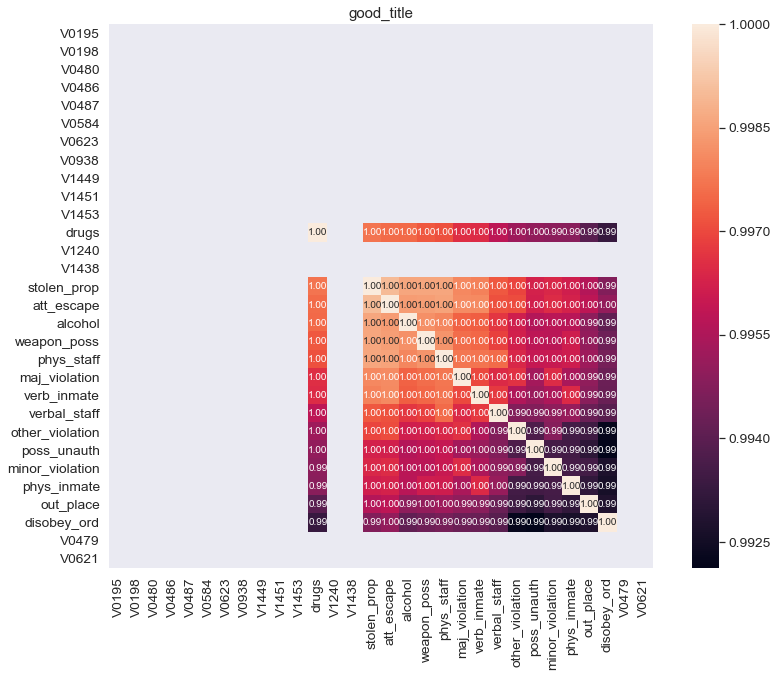

In [39]:
heatmap(df, 30, 'drugs', 'good_title')

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5,
                           bootstrap=True, 
                            verbose=1, n_jobs=-1, random_state=seed)

In [40]:
'drugs' in df.columns

True

In [41]:
for x in df.columns:
    print(x)

Index(['V0195', 'V0198', 'V0480', 'V0486', 'V0487', 'V0584', 'V0623', 'V0938',
       'V1449', 'V1451', 'V1453', 'drugs', 'V1240', 'V1438', 'stolen_prop',
       'att_escape', 'alcohol', 'weapon_poss', 'phys_staff', 'maj_violation',
       'verb_inmate', 'verbal_staff', 'other_violation', 'poss_unauth',
       'minor_violation', 'phys_inmate', 'out_place', 'disobey_ord', 'V0479',
       'V0621'],
      dtype='object')
V0001
V0002
V0003
V0004
V0005
V0006
V0007
V0008
V0009
V0013
V0014
V0015
V0016
V0017
V0018
V0019
V0020
V0021
V0022
V0023
V0024
V0025
V0026
V0027
V0028
V0029
V0030
V0031
V0032
V0033
V0034
V0035
V0036
V0037
V0038
V0039
V0040
V0041
V0042
V0043
V0044
V0045
V0046
V0049
V0051
V0052
V0055
V0057
V0058
V0059
V0060
V0061
V0062
V0063
V0064
V0065
V0066
V0067
V0068
V0069
V0070
V0071
V0072
V0073
V0074
V0075
V0076
V0077
V0078
V0079
V0080
V0081
V0082
V0083
V0084
V0085
V0086
V0087
V0088
V0089
V0090
V0091
V0092
V0093
V0094
V0095
V0096
V0097
V0098
V0099
V0100
V0101
V0102
V0103
V0104
V0105
V0

V1857
V1858
V1859
V1860
V1861
V1862
V1863
V1864
V1865
V1866
V1867
V1868
V1869
V1870
V1871
V1872
V1873
V1874
V1875
V1876
V1877
V1878
V1879
V1880
V1881
V1882
V1883
V1884
V1885
V1886
V1887
V1888
V1889
V1890
V1891
V1892
V1893
V1894
V1895
V1896
V1897
V1898
V1899
V1900
V1901
V1902
V1903
V1904
V1905
V1906
V1907
V1908
V1909
V1910
V1911
V1912
V1913
V1914
V1915
V1916
V1917
V1918
V1919
V1920
V1921
V1922
V1923
V1924
V1925
V1926
V1927
V1928
V1929
V1930
V1931
V1932
V1933
V1934
V1935
V1936
V1937
V1938
V1939
V1940
V1941
V1942
V1943
V1944
V1945
V1946
V1947
V1948
V1949
V1950
V1951
V1952
V1953
V1954
V1955
V1956
V1957
V1958
V1959
V1960
V1961
V1962
V1963
V1964
V1965
V1966
V1967
V1968
V1969
V1970
V1971
V1972
V1973
V1974
V1975
V1976
V1977
V1978
V1979
V1980
V1981
V1982
V1983
V1984
V1985
V1986
V1987
V1988
V1989
V1990
V1991
V1992
V1993
V1994
V1995
V1996
V1997
V1998
V1999
V2000
V2001
V2002
V2003
V2004
V2005
V2006
V2007
V2008
V2009
V2010
V2011
V2012
V2013
V2014
V2015
V2016
V2017
V2018
V2019
V2020
V2021
V2022
V202

CH_NUMCAR5
CH_CRIM_HISTORY


In [42]:
#Creates a heatmap to compare the top features most correlated with saleprice
def neg_heatmap(data, num_features, primary_feature, title):
    corrmat = data.corr()
    columns = corrmat.nsmallest(num_features, primary_feature)[primary_feature].index
    cm = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(14, 10))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    plt.title(title)
    plt.show()
    print(columns)
    return

In [43]:
neg_heatmap(df, 30, 'drugs', 'good_title')

KeyboardInterrupt: 

In [147]:
to_replace = [9999999.98, 9999998.00, 9999997.00, 9.980000e+059]
X.replace(to_replace, np.nan, inplace=True)
pd.get_dummies(X.fillna(0)).max().sort_values(ascending=False)

CH_EXPECTEDTIMEMTH               5.555555e+06
V0911                            1.000000e+06
V0831                            9.000000e+05
V0986                            1.000000e+05
V2974                            1.000000e+05
V0001                            1.940100e+04
V0906                            1.700000e+04
CS_SENTENCEMTH                   1.000000e+04
V2628                            1.000000e+04
V2726                            1.000000e+04
V2720                            1.000000e+04
V2721                            1.000000e+04
V2722                            1.000000e+04
V2723                            1.000000e+04
V2724                            1.000000e+04
V2725                            1.000000e+04
V2727                            1.000000e+04
V2735                            1.000000e+04
V2728                            1.000000e+04
V2729                            1.000000e+04
V2730                            1.000000e+04
V2731                            1

In [148]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5,
                            bootstrap=True, max_features='auto',
                            verbose=1, n_jobs=-1, random_state=seed)

In [156]:
with pd.option_context('mode.use_inf_as_null', True):
    rf.fit(X.applymap(float),violator)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [151]:
pd.get_dummies(X).applymap(float)

,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,V0013,...,V1061_TN,V1061_TX,V1061_UT,V1061_VA,V1061_VT,V1061_WA,V1061_WI,V1061_WV,V1061_WY,V2605_999999999999999999999
0,15717.0,10.0,201.0,2.0,2.0,0.0,5.0,10.0,215.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,15718.0,10.0,201.0,2.0,2.0,0.0,5.0,8.0,310.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,15719.0,10.0,201.0,2.0,2.0,0.0,5.0,2.0,145.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15720.0,10.0,201.0,2.0,2.0,0.0,5.0,6.0,150.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,15721.0,10.0,201.0,2.0,2.0,0.0,4.0,11.0,183.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,15722.0,10.0,201.0,2.0,2.0,0.0,5.0,6.0,155.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,15723.0,10.0,201.0,2.0,2.0,0.0,5.0,8.0,160.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,15724.0,10.0,201.0,2.0,2.0,0.0,5.0,7.0,165.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,15725.0,10.0,201.0,2.0,2.0,0.0,5.0,2.0,178.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,15726.0,10.0,201.0,2.0,2.0,0.0,5.0,6.0,220.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [154]:
all(pd.get_dummies(X.fillna(0)).isfinite())

AttributeError: 'DataFrame' object has no attribute 'isfinite'

In [155]:
pd.get_dummies(X).shape

(18185, 3286)

In [158]:
# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# import lightgbm as lgb

In [169]:
logit = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1500).fit(np.array(pd.get_dummies(X).fillna(0), dtype='float64'), violator)
logit.predict(pd.get_dummies(X).fillna(0))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [162]:
np.array(pd.get_dummies(X.fillna(0))).dtype

dtype('float64')

In [168]:
np.array(pd.get_dummies(X.fillna(0))).any()

True

In [173]:
np.isinf(np.array(pd.get_dummies(X).fillna(0), dtype='float64')).any()

False

In [175]:
pd.get_dummies(X).fillna(0).isnull().any().any()

False